# Диплом 2024 GeekBrains
### Анализ предсказаний курсов валют с помощью модели машинного обучения на разный промежуток времени в зависимости от ключевых индикаторов на фондовом рынке

### Содержание:
- [Установка необходимых пакетов, если они не установлены](#inst_)
- [Импорт библиотек](#libr_)
- [Загрузка датасетов](#load_data_)
  - [Описание данных](#description_)
- [Разведочный анализ даных (EDA)](#eda_)
  - [Посмотрим типы данных](#dtypes_)
  - [Посмотрим пропуски данных](#pass_)
  - [Посмотри статистику по дата фрейму](#statistics_)
  - [Визуализируем данные](#visual_)
    - [Выделим численные признаки от даты](#num_and_char_)
    - [Создадим словарь признаков и пояснения](#translate_)
    - [Визуализируем распределение числовых признаков](#num_visual_)
- [Предобработка признаков](#predobrabotka_)
  - [Посмотрим какие признаки имеют выбросы](#vibros_)
- [Создание новых признаков](#new_priznak_)
- [Проверка состояния данных](#data_status_)
- [Метрика по которой будем оценивать качество работы модели](#metrika_)
- [Разбиение временного ряда на train и test](#train_test_split_)
- [Функция кросс-валидации](#cross_val_)
- [Создание модели и дата фрейма для хранения результатов кросс-валидации](#model_df_)
- [Кросс-валидация данных](#cross_val_data_)
  - [С шагом в год](#year_)
  - [С шагом в квартал](#quarter_)
  - [С шагом в месяц](#month_)
  - [С шагом в неделю](#week_)
- [Визуализация результатов кросс-валидации](#visual_cross_val_)
- [Важность признаков модели](#importance_of_signs_)
- [Средняя ошибка предсказаний модели в зависимости от длительности периода предсказаний](#kachestvo_)
- [Вывод](#vivod_)

### Установка пакетов если они не установлены <a class='anchor' id='inst_'>

In [1]:
# Для кождого проекта я использую новое окружение, 
# думаю это помогает избежать ошибок связанных с версиями пакетов
# !pip install pandas
# !pip install matplotlib
# !pip install seaborn
# !pip install numpy
# !pip install scikit-learn
# !pip install openpyxl

### Импортируем библиотеки <a class='anchor' id='libr_'>

In [2]:
# Импортируем необходимые библиотеки
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
# Следующая магическая команда Jupyter Notebook нужна для того, чтобы графики
# отображались прямо в ноутбуке, а не в отдельном окне
%matplotlib inline

# Настройка более четкого отображения графиков
%config InlineBackend.figure_format = 'svg'

# Модуль для зазбиения выборки на тренировочнию и тестовую
from sklearn.model_selection import train_test_split

# Уберем warnings
import warnings
warnings.filterwarnings('ignore')

# Настройка формата вывода чисел float
pd.set_option('display.float_format', '{:.2f}'.format)

# Вычисление Z-score
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from scipy.stats.mstats import winsorize

# Дата и время
from datetime import datetime

# Случайные числа
import random as rnd

# Алгоритм машинного обучения 'Метод случайного леса'
from sklearn.ensemble import RandomForestRegressor

# Кросс-валидация 
from sklearn.model_selection import cross_validate

# Разбиение
from sklearn.model_selection import KFold

# Метрика r2
from sklearn.metrics import r2_score

# Пути файловой системы
from pathlib import Path

# Регулярные выражения
import re

# Округление числа в большую сторону
from math import ceil

### Загружаем данные <a class='anchor' id='load_data_'>

Описание данных: <a class='anchor' id='description_'>    
- Файлы находящиеся в директории описанной константой `PATH_DATASET` и имеющие расширение `xlsx` будут загружены. Если число строк больше или равно значению переменной `MIN_ROW`, то данные будут соединены в один дата фрейм по столбцу `Дата`.  
- В директории располагаются данные о ключевых индикаторах фондового рынка и курсах валют. Если в названии файла есть знак `_`, то он определяется как курс валюты и будет считаться таргетом , если нет, то будет определятся как ключевой индикатор фондового рынка и буудет считаться признаком.
В дата фрейме название столбца будет соответствовать названию файла    
- Данные загружаются с различных фалов Excel и соединяются между собой по столбцу `Дата`.  О ходе процесса выводиться информация на консоль.
Файлы могут содержать любую информацию о ключевых показателях фондового рынка и курсах любых валют.  

In [3]:
# Расположение данных
PATH_DATASET = './Dataset'
# Минимальное разрешённое количество строк для загрузки
MIN_ROW = 5000
# Итоговый датафрейм со всеми данными
data_loaded = pd.DataFrame()
# Расположение файлов датасета
p = Path(Path.cwd() / PATH_DATASET)

for obj in p.iterdir():
    if obj.is_file():
        *_, name_file_all = str(obj).split('\\')
        name_file, type_file = name_file_all.split('.')
        if type_file == 'xlsx':
            df_temp = pd.read_excel(f'{PATH_DATASET}/{name_file_all}')
            # Переименуем стобцы
            df_temp.rename(columns={'Значение': f'{name_file}'}, inplace=True)
            # Нормализуем дату
            df_temp['Дата'] = df_temp['Дата'].dt.normalize()
            # Проверяем условие первой загрузки
            if data_loaded.shape[1]:
                if df_temp.shape[0] >= MIN_ROW:
                    print(f'Обработан: {name_file_all} {df_temp.shape}')
                    data_loaded = pd.merge(data_loaded, df_temp, on='Дата', how='inner')
                    print(f'Размерность после merge {data_loaded.shape}\n')
                else:
                    print(f'Отклонён, мало строк: {name_file_all}\n')
            else:
                data_loaded = df_temp
                print(f'Обработан: {name_file_all} {df_temp.shape}\n')

Обработан: chf_rub-(банк-россии).xlsx (7303, 2)

Обработан: cny_rub-(банк-россии).xlsx (5419, 2)
Размерность после merge (5419, 3)

Обработан: eur_rub-(банк-россии).xlsx (7303, 2)
Размерность после merge (5419, 4)

Обработан: gbp_rub-(банк-россии).xlsx (7303, 2)
Размерность после merge (5419, 5)

Обработан: jpy_rub-(банк-россии).xlsx (7303, 2)
Размерность после merge (5419, 6)

Обработан: s-p-500.xlsx (6178, 2)
Размерность после merge (4303, 7)

Обработан: usd_rub-(банк-россии).xlsx (7303, 2)
Размерность после merge (4303, 8)

Отклонён, мало строк: бивалютная-корзина_rub.xlsx

Обработан: золото-(банк-россии).xlsx (6034, 2)
Размерность после merge (4285, 9)

Обработан: индекс-мосбиржи.xlsx (6130, 2)
Размерность после merge (4185, 10)

Обработан: нефть-brent.xlsx (6514, 2)
Размерность после merge (4185, 11)

Обработан: палладий-(банк-россии).xlsx (6838, 2)
Размерность после merge (4185, 12)

Обработан: платина-(банк-россии).xlsx (6912, 2)
Размерность после merge (4185, 13)

Обработан: рт

In [4]:
# Посмотрим, что загрузилось
data_loaded.head()

,Дата,chf_rub-(банк-россии),cny_rub-(банк-россии),eur_rub-(банк-россии),gbp_rub-(банк-россии),jpy_rub-(банк-россии),s-p-500,usd_rub-(банк-россии),золото-(банк-россии),индекс-мосбиржи,нефть-brent,палладий-(банк-россии),платина-(банк-россии),ртс,серебро-(банк-россии)
0,2024-07-09,98.46,11.98,95.66,112.84,0.55,5576.98,88.17,6743.87,3054.07,84.66,2908.39,2899.89,1093.26,86.68
1,2024-07-08,98.11,12.01,95.57,112.48,0.55,5572.85,88.13,6683.46,3132.58,85.64,2904.44,2867.60,1119.25,85.96
2,2024-07-05,97.77,11.99,94.98,112.46,0.55,5567.19,88.12,6690.03,3149.29,86.97,2954.96,2835.97,1125.66,85.36
3,2024-07-03,97.33,11.90,93.69,111.28,0.54,5537.02,87.99,6589.05,3203.07,86.63,2795.06,2786.57,1147.28,82.73
4,2024-07-02,96.98,11.80,93.96,110.36,0.54,5509.01,87.30,6542.06,3217.29,86.24,2728.08,2840.35,1151.82,82.43


In [5]:
# Посмотрим размер
data_loaded.shape

(4178, 15)

### Разведочный анализ даных (EDA) <a class='anchor' id='eda_'>

#### Посмотрим типы данных <a class='anchor' id='dtypes_'>

In [6]:
data_loaded.dtypes

Дата                      datetime64[ns]
chf_rub-(банк-россии)            float64
cny_rub-(банк-россии)            float64
eur_rub-(банк-россии)            float64
gbp_rub-(банк-россии)            float64
jpy_rub-(банк-россии)            float64
s-p-500                          float64
usd_rub-(банк-россии)            float64
золото-(банк-россии)             float64
индекс-мосбиржи                  float64
нефть-brent                      float64
палладий-(банк-россии)           float64
платина-(банк-россии)            float64
ртс                              float64
серебро-(банк-россии)            float64
dtype: object

#### Посмотрим пропуски данных <a class='anchor' id='pass_'>

In [7]:
# Проверка того, в каких столбцах отсутствуют значения
print(data_loaded.isnull().sum(axis=0))

Дата                      0
chf_rub-(банк-россии)     0
cny_rub-(банк-россии)     0
eur_rub-(банк-россии)     0
gbp_rub-(банк-россии)     0
jpy_rub-(банк-россии)     0
s-p-500                   0
usd_rub-(банк-россии)     0
золото-(банк-россии)      0
индекс-мосбиржи           0
нефть-brent               0
палладий-(банк-россии)    0
платина-(банк-россии)     0
ртс                       0
серебро-(банк-россии)     0
dtype: int64


#### Посмотри статистику по дата фрейму <a class='anchor' id='statistics_'>

In [8]:
data_loaded.describe()

,Дата,chf_rub-(банк-россии),cny_rub-(банк-россии),eur_rub-(банк-россии),gbp_rub-(банк-россии),jpy_rub-(банк-россии),s-p-500,usd_rub-(банк-россии),золото-(банк-россии),индекс-мосбиржи,нефть-brent,палладий-(банк-россии),платина-(банк-россии),ртс,серебро-(банк-россии)
count,4178,4178.00,4178.00,4178.00,4178.00,4178.00,4178.00,4178.00,4178.00,4178.00,4178.00,4178.00,4178.00,4178.00,4178.00
mean,2015-06-14 12:44:07.008137984,52.65,7.53,60.02,71.82,0.46,2351.96,50.66,2406.81,2017.93,77.91,1889.29,1775.77,1325.14,33.01
min,2006-05-11 00:00:00,20.90,3.28,33.72,40.48,0.21,682.55,23.13,486.82,513.62,19.33,144.32,664.78,498.20,7.81
25%,2010-12-02 06:00:00,31.14,4.59,40.38,49.77,0.34,1362.70,30.46,1296.15,1462.82,59.92,594.88,1504.21,1072.07,20.97
50%,2015-06-18 12:00:00,58.02,8.43,60.63,72.17,0.44,2047.40,56.50,2246.76,1765.40,75.29,1235.60,1714.11,1274.45,31.27
75%,2019-12-11 18:00:00,67.60,9.98,75.22,89.35,0.59,3003.95,66.34,3114.67,2444.39,98.47,3069.00,2051.12,1534.68,37.67
max,2024-07-09 00:00:00,115.22,16.19,113.26,136.04,0.85,5576.98,103.16,7231.12,4287.52,146.08,8507.40,3396.33,2487.92,92.42
std,NaN,24.32,3.10,20.66,23.10,0.15,1184.29,21.26,1536.95,752.57,23.96,1751.72,510.58,361.29,17.51


### Визуализируем данные <a class='anchor' id='visual_'>

#### Выделим численные признаки от даты <a class='anchor' id='num_and_char_'>

In [9]:
# Создадим список численных признаков
num_cols = [column for column in data_loaded if not column=='Дата']
num_cols

['chf_rub-(банк-россии)',
 'cny_rub-(банк-россии)',
 'eur_rub-(банк-россии)',
 'gbp_rub-(банк-россии)',
 'jpy_rub-(банк-россии)',
 's-p-500',
 'usd_rub-(банк-россии)',
 'золото-(банк-россии)',
 'индекс-мосбиржи',
 'нефть-brent',
 'палладий-(банк-россии)',
 'платина-(банк-россии)',
 'ртс',
 'серебро-(банк-россии)']

#### Создадим словарь признаков и пояснения <a class='anchor' id='translate_'>

In [10]:
# Словарь признаков и их пояснения
explanations_col = {
    'chf_rub-(банк-россии)': 'Швейцарский франк / Российский рубль',
    'eur_rub-(банк-россии)': 'Евро / Российский рубль',
    'gbp_rub-(банк-россии)': 'Британский фунт стерлингов / Российский рубль',
    'jpy_rub-(банк-россии)': 'Японская иена / Российский рубль',
    's-p-500': 'Индекс S&P 500',
    'usd_rub-(банк-россии)': 'Доллар США / Российский рубль',
    'cny_rub-(банк-россии)': 'Китайский юань / Российский рубль'
}

#### Визуализируем распределение числовых признаков <a class='anchor' id='num_visual_'>

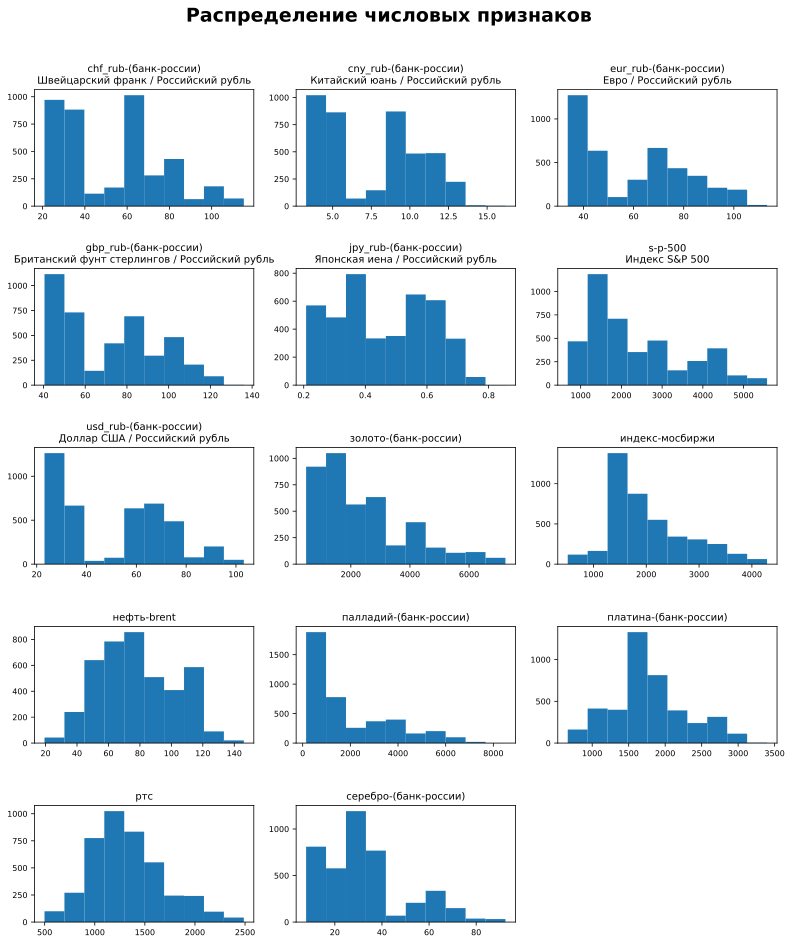

In [11]:
# Создаём полотно
plt.figure(figsize=[11, 13])

# Общий заголовок для всех графиков
plt.suptitle('Распределение числовых признаков ', 
                y=1.005, 
                fontsize=19, 
                fontweight='bold')

# Рассчитаем количество строк в графике
n_row = ceil(len(num_cols)/3)

for i, col in enumerate(num_cols):
    plt.subplot(n_row, 3, i+1)
    # Заголовок для графика
    # Вставляем русский перевод если он есть, или оригинальное название
    explanations = col + '\n' + explanations_col[col] if explanations_col.get(col) else '\n' + col
    plt.title(f'\n{explanations}', fontsize=10)
    # Задаём размер шривта и угол поворота текста для осей X и Y
    plt.xticks(fontsize=8, rotation=0)
    plt.yticks(fontsize=8, rotation=0)
    # Делаем размер шрифта по Y=5, не уберая название оси
    plt.ylabel('', fontsize=5)
    # Отрисовываем гистограмму
    plt.hist(data_loaded[col])

# Автоматически уместить все элементы на полотне    
plt.tight_layout()

# Вывести графики на экран
plt.show()

### Предобработка признаков <a class='anchor' id='predobrabotka_'>

#### Посмотрим какие признаки имеют выбросы <a class='anchor' id='vibros_'>

In [12]:
def emission_test(ds, col_test, threshold_val=3, explanations_col=explanations_col):
    '''
    Функция проводит тестирование столбцов на выбросы методом Z-score.
    
    :param ds: исследуемый датасет,
    :param col_test: список колонок,
    :param threshold_val: пороговое значение Z-score,
    :param explanations_col: словарь признаков и их пояснения,
    :return: текстовый отчет и список выбросов.
    '''
    result = ''
    NUM = 2  # количество цифр после запятой
    outliers_list = [] # лист выбросов
    for col in col_test:
        # Вычисление Z-score
        z = np.abs(stats.zscore(ds[col]))
        # Установка порогового значения Z-score
        threshold = 3
        # Выявление выбросов на основе Z-score
        outliers = ds[col][z > threshold]
        
        if len(outliers) > 0:
            outliers_list.append(outliers)

            # Вставляем русский перевод если он есть, или оригинальное название
            explanations = f' ({explanations_col[col]})' if explanations_col.get(col) else ''
            
            result += f'В столбце {col}{explanations},\n{len(outliers)} выбросов. Mean: {round(ds[col].mean(), NUM)}, ' \
            f'Min: {round(ds[col].min(), NUM)}, Max: {round(ds[col].max(), NUM)}, ' \
            f'Moda: {round(ds[col].mode()[0], NUM)}, Median: {round(ds[col].median(), NUM)} \n\n'
    
    return f'Выбросов нет. ' if result == '' else result, outliers_list

In [13]:
def viev_outliers(outliers_list, col_name):
    '''
    Функция выводит строки датафрейма, в которых есть выбросы.
    
    :param outliers_list: список выбросов,
    :param col_name: название признака (фичи),
    :return: индексы выбросов.
    '''
    for item in outliers:
        if item.name == col_name:
            return item.index 

In [14]:
# Выведем признаки которые имеют выбросы
text_outliers, outliers = emission_test(ds=data_loaded, col_test=num_cols)

In [15]:
# Выведем текстовый отчёт по выбросам
print(text_outliers)

В столбце золото-(банк-россии),
11 выбросов. Mean: 2406.81, Min: 486.82, Max: 7231.12, Moda: 5993.16, Median: 2246.76 

В столбце индекс-мосбиржи,
3 выбросов. Mean: 2017.93, Min: 513.62, Max: 4287.52, Moda: 647.8, Median: 1765.4 

В столбце палладий-(банк-россии),
6 выбросов. Mean: 1889.29, Min: 144.32, Max: 8507.4, Moda: 3275.71, Median: 1235.6 

В столбце платина-(банк-россии),
1 выбросов. Mean: 1775.77, Min: 664.78, Max: 3396.33, Moda: 2883.54, Median: 1714.11 

В столбце ртс,
11 выбросов. Mean: 1325.14, Min: 498.2, Max: 2487.92, Moda: 982.94, Median: 1274.45 

В столбце серебро-(банк-россии),
21 выбросов. Mean: 33.01, Min: 7.81, Max: 92.42, Moda: 32.11, Median: 31.27 




### Создание новых признаков <a class='anchor' id='new_priznak_'>

In [16]:
def choice_quarter(month):
    '''
    Функция определения квартала.

    :param month: номер месяца 1-12,
    :return: номер квартала 1-4, или -1, если ошибка.
    '''
    if month <= 3:
        return 1
    elif 4 <= month <= 6:
        return 2
    elif 7 <= month <= 9:    
        return 3
    elif 10 <= month <= 12:    
        return 4
    else:
        return -1

In [17]:
# Создадим дополнительные признаки (год, месяц, день, день недели (Пн-Вс), номер недели, квартал)
data_loaded['Year'] = data_loaded['Дата'].dt.year
data_loaded['Month'] = data_loaded['Дата'].dt.month
data_loaded['Weekday'] = data_loaded['Дата'].dt.weekday
data_loaded['Day'] = data_loaded['Дата'].dt.day
data_loaded['Week'] = data_loaded['Дата'].dt.isocalendar().week
data_loaded['Quarter'] = data_loaded['Month'].apply(lambda x: choice_quarter(x))

data_loaded.head()

,Дата,chf_rub-(банк-россии),cny_rub-(банк-россии),eur_rub-(банк-россии),gbp_rub-(банк-россии),jpy_rub-(банк-россии),s-p-500,usd_rub-(банк-россии),золото-(банк-россии),индекс-мосбиржи,...,палладий-(банк-россии),платина-(банк-россии),ртс,серебро-(банк-россии),Year,Month,Weekday,Day,Week,Quarter
0,2024-07-09,98.46,11.98,95.66,112.84,0.55,5576.98,88.17,6743.87,3054.07,...,2908.39,2899.89,1093.26,86.68,2024,7,1,9,28,3
1,2024-07-08,98.11,12.01,95.57,112.48,0.55,5572.85,88.13,6683.46,3132.58,...,2904.44,2867.60,1119.25,85.96,2024,7,0,8,28,3
2,2024-07-05,97.77,11.99,94.98,112.46,0.55,5567.19,88.12,6690.03,3149.29,...,2954.96,2835.97,1125.66,85.36,2024,7,4,5,27,3
3,2024-07-03,97.33,11.90,93.69,111.28,0.54,5537.02,87.99,6589.05,3203.07,...,2795.06,2786.57,1147.28,82.73,2024,7,2,3,27,3
4,2024-07-02,96.98,11.80,93.96,110.36,0.54,5509.01,87.30,6542.06,3217.29,...,2728.08,2840.35,1151.82,82.43,2024,7,1,2,27,3


### Проверка состояния данных <a class='anchor' id='data_status_'>

In [18]:
def not_correct_year(df=data_loaded, min_month=12, min_day=200):
    '''
    Функция выдает список не корректных годов, где min_month и min_day меньше заданного.

    :param  df: исследуемый датафрейм,
    :param  min_month: минимальное количество месяцев в году,
    :param  min_day: минимальное количество дней в году,
    :return: возвращает список не корректных годов и текстовый отчёт.
    '''

    not_corr_year = []
    txt_report = ''
    
    for year in df['Year'].unique():
        month_quantity = len(df[df['Year']==year]['Month'].unique())
        day_quantity = len(df[df['Year']==year]['Weekday'])
        if (month_quantity < min_month) or (day_quantity < min_day):
            not_corr_year.append(int(year))
        txt_report += f'Год: {year}, кол. месяцев: {month_quantity}, кол. дней: {day_quantity}\n'

    return not_corr_year, txt_report

In [19]:
# Протестируем датасет и запишем список не корректных годов и отчёт
not_correct_year_list, report = not_correct_year()
print(report)

Год: 2024, кол. месяцев: 7, кол. дней: 124
Год: 2023, кол. месяцев: 12, кол. дней: 237
Год: 2022, кол. месяцев: 12, кол. дней: 214
Год: 2021, кол. месяцев: 12, кол. дней: 233
Год: 2020, кол. месяцев: 12, кол. дней: 225
Год: 2019, кол. месяцев: 12, кол. дней: 232
Год: 2018, кол. месяцев: 12, кол. дней: 227
Год: 2017, кол. месяцев: 12, кол. дней: 232
Год: 2016, кол. месяцев: 12, кол. дней: 232
Год: 2015, кол. месяцев: 12, кол. дней: 231
Год: 2014, кол. месяцев: 12, кол. дней: 233
Год: 2013, кол. месяцев: 12, кол. дней: 232
Год: 2012, кол. месяцев: 12, кол. дней: 230
Год: 2011, кол. месяцев: 12, кол. дней: 232
Год: 2010, кол. месяцев: 12, кол. дней: 224
Год: 2009, кол. месяцев: 12, кол. дней: 230
Год: 2008, кол. месяцев: 12, кол. дней: 226
Год: 2007, кол. месяцев: 12, кол. дней: 227
Год: 2006, кол. месяцев: 8, кол. дней: 157



### Метрика по которой будем оценивать качество работы модели <a class='anchor' id='metrika_'>

In [20]:
# Метрика
def mape(y_test, y_pred):
    '''
    Функция вычисляет ошибку в процентах от средних значений предсказанных и тестовых.

    :param  y_test: тестовые значения таргета,
    :param  y_pred: предсказанные значения таргета,
    :return: возвращает ошибку предсказания в процентах.
    '''
    return abs((y_test.mean() - y_pred.mean()) / y_test.mean()) * 100

### Разбиение временного ряда на train и test <a class='anchor' id='train_test_split_'>

In [21]:
def split_on_time_series(data, start_year, number_splits, type_split, target_name):
    '''
    Функция-генератор, разбивает временной ряд на train и test.

    :param  data: датафрем с данными,
    :param  start_year: год с которого будем разбивать,
    :param  number_splits: количество разбиений,
    :param  type_split: тип разбиений (Year, Quarter, Month, Week),
    :param  target_name: имя таргета (целевой переменной),
    :return: возвращает X_train, y_train, X_test, y_test, summary, time_point_test.
    '''
    # Удаляем все не латинские знаки, делаем первую букву заглавную, остальные обычные
    resample_param = re.sub(r'[^a-zA-z]', '', type_split).capitalize()
    resample_code = ''
    # Создадим список валют
    currency_list = [column for column in data if '_' in column]
    # Тригер первого включения
    triger = False
    
    # Выставляем параметр для сводной таблицы
    if resample_param == 'Year':
        resample_code = 'YE'
    elif resample_param == 'Quarter':
        resample_code = 'BQE'
    elif resample_param == 'Month':
        resample_code = 'ME'
    elif resample_param == 'Week':
        resample_code = 'W'    
    else:
        raise ValueError(f'Ошибка параметра "type_split={type_split}". Корректно: Year, Quarter, Month, Week') 

    # Делаем датафрем независимым
    df = data.copy(deep=True)
    # Сделаем резервную копию даты
    df['Дата-copy'] = df['Дата']
    # Установим столбец даты в качестве индекса
    df = df.set_index('Дата-copy')
    # Выберем данные после стартового года
    df = df.query(f'(Year >= {start_year})')

    # Создадим X_train и y_train
    # Делаем датафрем независимым
    X_train = data.copy(deep=True)
    X_train = X_train.query(f'(Year < {start_year})')
    # Установим столбец даты в качестве индекса
    X_train = X_train.set_index('Дата')
    # Создадим таргет
    y_train = X_train[target_name] 
    # Удалим все ненужные столбцы из X_train
    X_train.drop(columns=currency_list, axis=1, inplace=True)
    
    # Проверка
    n_row = df.resample(resample_code).count().shape[0]
    if n_row < number_splits:
        raise ValueError(f'Столько данных с параметрами "start_year={start_year}", не найдём ((')
    
    # Если всё ок разбиваем на train и test
    for row in range(number_splits):
        # Добавляем данные из предыдущего цикла, если он не первый
        if triger:
            X_train = pd.concat([X_train, X_test]).sort_index(ascending=False)
            y_train = pd.concat([y_train, y_test]).sort_index(ascending=False)
        else:
            triger = True
        # Читаем строчку сводной таблицы
        resample_param_list = ['Year']
        if not resample_param in resample_param_list:
            resample_param_list.append(resample_param)
        pivot_table_row = pd.DataFrame(df.resample(resample_code).mean().iloc[row]).T[resample_param_list]
        # Соединяем таблицу и строку сводной таблицы
        result = df.merge(pivot_table_row, on=resample_param_list, how='right')
        result = result.set_index('Дата')
        # Запишем таргет в отдельную переменную
        y_test = result[target_name]
        # Удалим все таргеты из датасета
        result.drop(columns=currency_list, axis=1, inplace=True)
        X_test = result
        # Инфа по данным
        summary = f'Train({X_train.index.min().strftime('%d.%m.%Y')}-{X_train.index.max().strftime('%d.%m.%Y')}, X.shape{X_train.shape}, y.shape{y_train.shape}), ' \
                  f'Test({X_test.index.min().strftime('%d.%m.%Y')}-{X_test.index.max().strftime('%d.%m.%Y')}, X.shape{X_test.shape}, y.shape{y_test.shape})'
        # Запишем переменные времени, для графика
        time_point_test = X_test.index.min()
        
        
        yield X_train, y_train, X_test, y_test, summary, time_point_test


### Функция кросс-валидации <a class='anchor' id='cross_val_'>

In [22]:
def cross_validation_time_series(model, df, year, n_split, type_split, currency, cv_info):
    '''
    Функция кросс-валидирует список валют на временном ряду.

    :param  model: ML модель которую будем использовать для кросс-валидации,
    :param  df: датафрейм с данными,
    :param  year: год с которого нужно начать кросс-валидацию,
    :param  n_split: число кросс-валидаций,
    :param  type_split: тип кросс валидаций (Year, Quarter, Month, Week),
    :param  currency: список полей валют,
    :param  cv_info: дата фрейм pandas куда будет записываться статистика о кросс-валидациях,
    :return: возвращает дата фрем статистики кросс-валидаций.    
    '''
    for currency_item in currency:
        for  X_train, y_train, X_test, y_test, summary, time_point_test in split_on_time_series(df, year, n_split, type_split, currency_item):
            # Обучим модель
            model.fit(X_train, y_train)
            # Выполним предикт
            y_pred = model.predict(X_test)
            # Посмотрим эффективность модели 
            cv_error = mape(y_test, y_pred)
            # Запишем статистику кросс валидации
            cv_info.loc[len(cv_info)]  = {'date':time_point_test, 'currency':currency_item, 'type_split':type_split, 'error':cv_error}
            # Сделал, чтобы выводилась статистика о ходе процесса
            print(f'{summary}, \nОшибка: {round(cv_error, 2)} %,  Валюта: {re.sub(r'[^a-zA-z_]', '', currency_item)}\n')

    return cv_info

### Создание модели и дата фрейма для хранения результатов кросс-валидации <a class='anchor' id='model_df_'>

In [23]:
# Создадим модель с количеством деревьев в лесу 2000, с максимальной глубиной залегания дерева 21
rf_model = RandomForestRegressor(n_estimators=2000, max_depth=21, random_state=42, criterion='squared_error')
# Обновим список валют
currency_list = [column for column in data_loaded if '_' in column]
# Датафрейм статистики кросс-валидации
cv_info = pd.DataFrame({'date':[], 'currency':[], 'type_split':[], 'error':[]})

### Кросс-валидация данных <a class='anchor' id='cross_val_data_'>

#### С шагом в год <a class='anchor' id='year_'>

In [24]:
%%time
# Будем кросс-валидировать 10 раз по году
cv_info = cross_validation_time_series(rf_model, data_loaded, 2013, 10, 'Year', currency_list, cv_info)

Train(11.05.2006-28.12.2012, X.shape(1526, 14), y.shape(1526,)), Test(10.01.2013-30.12.2013, X.shape(232, 14), y.shape(232,)), 
Ошибка: 5.29 %,  Валюта: chf_rub

Train(11.05.2006-30.12.2013, X.shape(1758, 14), y.shape(1758,)), Test(10.01.2014-30.12.2014, X.shape(233, 14), y.shape(233,)), 
Ошибка: 18.19 %,  Валюта: chf_rub

Train(11.05.2006-30.12.2014, X.shape(1991, 14), y.shape(1991,)), Test(13.01.2015-30.12.2015, X.shape(231, 14), y.shape(231,)), 
Ошибка: 11.26 %,  Валюта: chf_rub

Train(11.05.2006-30.12.2015, X.shape(2222, 14), y.shape(2222,)), Test(12.01.2016-30.12.2016, X.shape(232, 14), y.shape(232,)), 
Ошибка: 4.85 %,  Валюта: chf_rub

Train(11.05.2006-30.12.2016, X.shape(2454, 14), y.shape(2454,)), Test(10.01.2017-29.12.2017, X.shape(232, 14), y.shape(232,)), 
Ошибка: 7.86 %,  Валюта: chf_rub

Train(11.05.2006-29.12.2017, X.shape(2686, 14), y.shape(2686,)), Test(10.01.2018-28.12.2018, X.shape(227, 14), y.shape(227,)), 
Ошибка: 3.66 %,  Валюта: chf_rub

Train(11.05.2006-28.12.201

#### С шагом в квартал <a class='anchor' id='quarter_'>

In [25]:
%%time
# Будем кросс-валидировать 10 раз по кварталу
cv_info = cross_validation_time_series(rf_model, data_loaded, 2022, 10, 'Quarter', currency_list, cv_info)

Train(11.05.2006-30.12.2021, X.shape(3603, 14), y.shape(3603,)), Test(11.01.2022-31.03.2022, X.shape(35, 14), y.shape(35,)), 
Ошибка: 6.52 %,  Валюта: chf_rub

Train(11.05.2006-31.03.2022, X.shape(3638, 14), y.shape(3638,)), Test(01.04.2022-30.06.2022, X.shape(54, 14), y.shape(54,)), 
Ошибка: 12.28 %,  Валюта: chf_rub

Train(11.05.2006-30.06.2022, X.shape(3692, 14), y.shape(3692,)), Test(01.07.2022-30.09.2022, X.shape(64, 14), y.shape(64,)), 
Ошибка: 5.32 %,  Валюта: chf_rub

Train(11.05.2006-30.09.2022, X.shape(3756, 14), y.shape(3756,)), Test(03.10.2022-30.12.2022, X.shape(61, 14), y.shape(61,)), 
Ошибка: 2.75 %,  Валюта: chf_rub

Train(11.05.2006-30.12.2022, X.shape(3817, 14), y.shape(3817,)), Test(10.01.2023-31.03.2023, X.shape(52, 14), y.shape(52,)), 
Ошибка: 1.32 %,  Валюта: chf_rub

Train(11.05.2006-31.03.2023, X.shape(3869, 14), y.shape(3869,)), Test(03.04.2023-30.06.2023, X.shape(59, 14), y.shape(59,)), 
Ошибка: 3.19 %,  Валюта: chf_rub

Train(11.05.2006-30.06.2023, X.shape(39

#### С шагом в месяц <a class='anchor' id='month_'>

In [26]:
%%time
# Будем кросс-валидировать 10 раз по месяцу
cv_info = cross_validation_time_series(rf_model, data_loaded, 2023, 10, 'Month', currency_list, cv_info)

Train(11.05.2006-30.12.2022, X.shape(3817, 14), y.shape(3817,)), Test(10.01.2023-31.01.2023, X.shape(15, 14), y.shape(15,)), 
Ошибка: 3.38 %,  Валюта: chf_rub

Train(11.05.2006-31.01.2023, X.shape(3832, 14), y.shape(3832,)), Test(01.02.2023-28.02.2023, X.shape(16, 14), y.shape(16,)), 
Ошибка: 4.48 %,  Валюта: chf_rub

Train(11.05.2006-28.02.2023, X.shape(3848, 14), y.shape(3848,)), Test(01.03.2023-31.03.2023, X.shape(21, 14), y.shape(21,)), 
Ошибка: 2.93 %,  Валюта: chf_rub

Train(11.05.2006-31.03.2023, X.shape(3869, 14), y.shape(3869,)), Test(03.04.2023-28.04.2023, X.shape(19, 14), y.shape(19,)), 
Ошибка: 1.41 %,  Валюта: chf_rub

Train(11.05.2006-28.04.2023, X.shape(3888, 14), y.shape(3888,)), Test(02.05.2023-31.05.2023, X.shape(20, 14), y.shape(20,)), 
Ошибка: 1.89 %,  Валюта: chf_rub

Train(11.05.2006-31.05.2023, X.shape(3908, 14), y.shape(3908,)), Test(01.06.2023-30.06.2023, X.shape(20, 14), y.shape(20,)), 
Ошибка: 3.03 %,  Валюта: chf_rub

Train(11.05.2006-30.06.2023, X.shape(392

#### С шагом в неделю <a class='anchor' id='week_'>

In [27]:
%%time
# Будем кросс-валидировать 10 раз по недели
cv_info = cross_validation_time_series(rf_model, data_loaded, 2024, 10, 'Week', currency_list, cv_info)

Train(11.05.2006-29.12.2023, X.shape(4054, 14), y.shape(4054,)), Test(03.01.2024-05.01.2024, X.shape(3, 14), y.shape(3,)), 
Ошибка: 1.61 %,  Валюта: chf_rub

Train(11.05.2006-05.01.2024, X.shape(4057, 14), y.shape(4057,)), Test(08.01.2024-12.01.2024, X.shape(5, 14), y.shape(5,)), 
Ошибка: 1.5 %,  Валюта: chf_rub

Train(11.05.2006-12.01.2024, X.shape(4062, 14), y.shape(4062,)), Test(16.01.2024-19.01.2024, X.shape(4, 14), y.shape(4,)), 
Ошибка: 1.33 %,  Валюта: chf_rub

Train(11.05.2006-19.01.2024, X.shape(4066, 14), y.shape(4066,)), Test(22.01.2024-26.01.2024, X.shape(5, 14), y.shape(5,)), 
Ошибка: 0.07 %,  Валюта: chf_rub

Train(11.05.2006-26.01.2024, X.shape(4071, 14), y.shape(4071,)), Test(29.01.2024-02.02.2024, X.shape(5, 14), y.shape(5,)), 
Ошибка: 0.99 %,  Валюта: chf_rub

Train(11.05.2006-02.02.2024, X.shape(4076, 14), y.shape(4076,)), Test(05.02.2024-09.02.2024, X.shape(5, 14), y.shape(5,)), 
Ошибка: 1.16 %,  Валюта: chf_rub

Train(11.05.2006-09.02.2024, X.shape(4081, 14), y.sha

### Визуализация результатов кросс-валидации <a class='anchor' id='visual_cross_val_'>

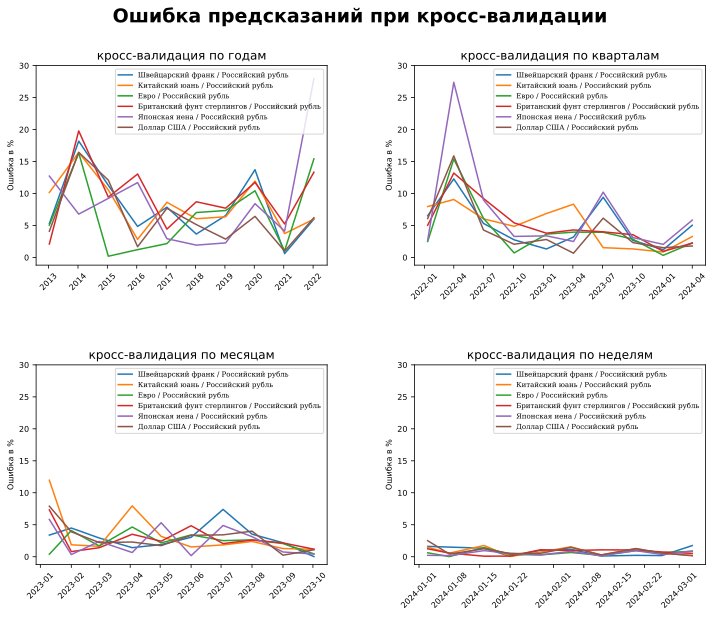

In [57]:
# Стиль легенды
legend_font = {
    "size": 7,
    "family": "serif",
}
# Стиль заголовков
title_font = {
    "fontsize": 12,
}

# Обновим список валют (на всякий случай)
currency_list = [column for column in data_loaded if '_' in column]

# Задаём размер полотна
plt.figure(figsize=[12, 9])

# Общий заголовок для всех графиков
plt.suptitle('Ошибка предсказаний при кросс-валидации', 
               y=0.97, 
               fontsize=19, 
               fontweight='bold')

# Строим 4-е графика 2х2
for i, type_split_item in enumerate(cv_info['type_split'].unique()):
    plt.subplot(2, 2, i+1)
    # Заголовок для графика
    split_type_dict = {
        'Year': 'годам',
        'Quarter':'кварталам',
        'Month':'месяцам',
        'Week':'неделям'}
    plt.title(f'кросс-валидация по {split_type_dict[type_split_item]}', fontdict=title_font)
    # Задаём размер шривта и угол поворота текста для осей X и Y
    plt.xticks(fontsize=8, rotation=45)
    plt.yticks(fontsize=8, rotation=0)
    # Делаем размер шрифта по Y=8
    plt.ylabel('Ошибка в %', fontsize=8)
    # Задаём границы графика
    plt.ylim(-1.2, 30)
    # Задаём расстояние меду графиками
    plt.subplots_adjust(wspace=0.3, hspace=0.5)
    # Отрисовываем графики
    for currency_item in currency_list:     
        # Создаём датафрем по условию валюты и типа разбиения (год, месяц и тд.)
        df_temp = cv_info.query(f'(currency == "{currency_item}") & (type_split == "{type_split_item}")')
        # Запишем переменные в x и y
        x = df_temp['date']
        y = df_temp['error']
        # Вставляем русский перевод если он есть, или оригинал, если перевода нет
        legend_text = explanations_col[currency_item] if explanations_col.get(currency_item) else currency_item
        # Отрисовываем график и легенду
        plt.plot(x, y, label=legend_text)
        # Выставляем стиль и положение легенды
        plt.legend(loc="upper right", prop=legend_font)
        
# Вывести графики на экран
plt.show()

### Важность признаков модели <a class='anchor' id='importance_of_signs_'>

Вычислим важность признаков для всех валют

In [29]:
%%time
# Словарь важности признаков
importance_of_signs = {}

# Пробежимся по всем валютам
for currency_item in currency_list:
    # Проитерируем функцию-генератор
    iterator = iter(split_on_time_series(data_loaded, 2024, 1, 'Year', currency_item))
    X_train, y_train, X_test, y_test, _, _ = next(iterator)
    # Объединим все данные в общий датафрейм и отсортируем по индексу (индекс - это дата)
    X_train = pd.concat([X_train, X_test]).sort_index(ascending=False)
    y_train = pd.concat([y_train, y_test]).sort_index(ascending=False)
    # Обучим модель на всех данных за весь период
    rf_model.fit(X_train, y_train)
    # Добавим в словарь важность признаков (ключ-валюта, значение-важность признаков)
    importance_of_signs[currency_item] = rf_model.feature_importances_

CPU times: total: 4min 24s
Wall time: 5min 30s


Отобразим важность признаков на графике

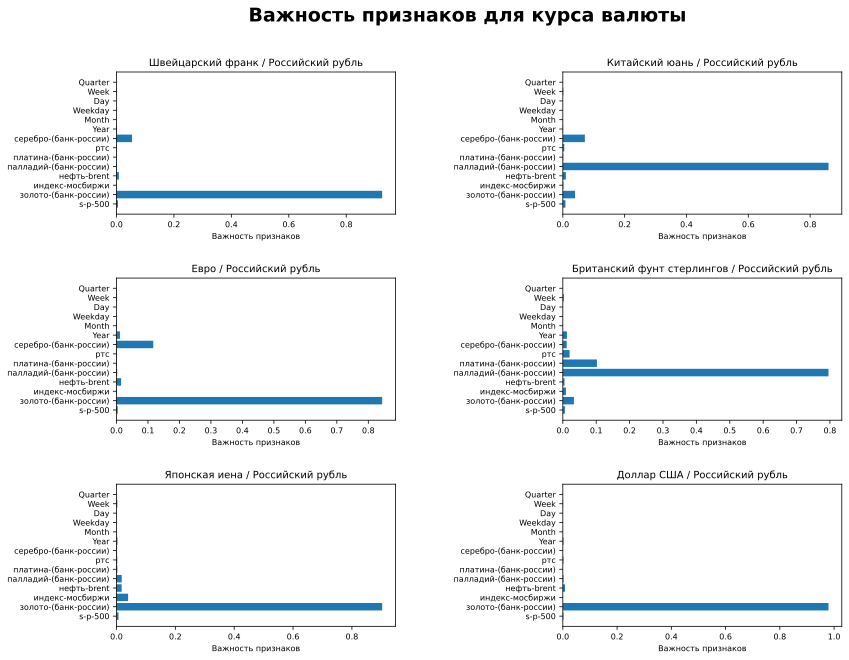

In [54]:
# Отрисуем графики важности для всех валют
# Стиль заголовков
title_font = {
    "fontsize": 10,
}

# Задаём размер полотна
plt.figure(figsize=[13, 10])

# Рассчитаем количество строк в графике
n_row = ceil(len(currency_list)/2)

# Общий заголовок для всех графиков
plt.suptitle('Важность признаков для курса валюты', 
               y=0.97, 
               fontsize=19, 
               fontweight='bold')

# Получим список всех фичей
feature_names = X_train.columns.values.tolist()

# Строим 4-е графика 2х2
for i, key in enumerate(importance_of_signs):
    plt.subplot(n_row, 2, i+1)
    # Вставляем русский перевод если он есть, или оригинал, если перевода нет
    title_text = explanations_col[key] if explanations_col.get(key) else key
    plt.title(title_text, fontdict=title_font)
    # Задаём размер шривта и угол поворота текста для осей X и Y
    plt.xticks(fontsize=8, rotation=0)
    plt.yticks(fontsize=8, rotation=0)
    # Делаем размер шрифта по Х=8 и задаём название оси
    plt.xlabel('Важность признаков', fontsize=8)
    # Задаём расстояние меду графиками
    plt.subplots_adjust(wspace=0.6, hspace=0.45)
    # Отрисовываем графики
    plt.barh(feature_names, importance_of_signs[key])
        
# Вывести графики на экран
plt.show()

### Средняя ошибка предсказаний модели в зависимости от длительности периода предсказаний <a class='anchor' id='kachestvo_'>

In [31]:
# Посмотрим, что записалось при кросс-валидации
cv_info

,date,currency,type_split,error
0,2013-01-10,chf_rub-(банк-россии),Year,5.29
1,2014-01-10,chf_rub-(банк-россии),Year,18.19
2,2015-01-13,chf_rub-(банк-россии),Year,11.26
3,2016-01-12,chf_rub-(банк-россии),Year,4.85
4,2017-01-10,chf_rub-(банк-россии),Year,7.86
...,...,...,...,...
235,2024-02-05,usd_rub-(банк-россии),Week,1.46
236,2024-02-12,usd_rub-(банк-россии),Week,0.29
237,2024-02-20,usd_rub-(банк-россии),Week,1.27
238,2024-02-26,usd_rub-(банк-россии),Week,0.57


In [32]:
# Сгруппируем средние значения в зависимости от типа разбиения и валюты
cv_info_mean = cv_info.groupby(['type_split', 'currency'], as_index=False).agg({'error':'mean'}).rename(columns={'error':'error_mean'}).sort_values(by='error_mean')
cv_info_mean

,type_split,currency,error_mean
16,Week,jpy_rub-(банк-россии),0.53
14,Week,eur_rub-(банк-россии),0.60
15,Week,gbp_rub-(банк-россии),0.74
13,Week,cny_rub-(банк-россии),0.84
12,Week,chf_rub-(банк-россии),0.89
17,Week,usd_rub-(банк-россии),0.89
4,Month,jpy_rub-(банк-россии),2.38
2,Month,eur_rub-(банк-россии),2.40
3,Month,gbp_rub-(банк-россии),2.83
5,Month,usd_rub-(банк-россии),3.01


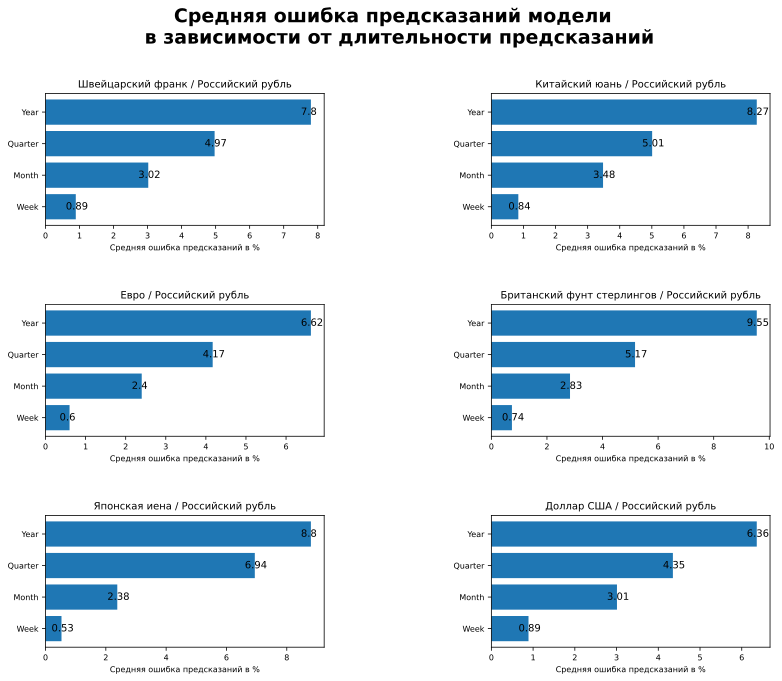

In [58]:
# Отрисуем графики важности для всех валют
# Стиль заголовков
title_font = {
    "fontsize": 10,
}

# Задаём размер полотна
plt.figure(figsize=[13, 10])

# Общий заголовок для всех графиков
plt.suptitle('Средняя ошибка предсказаний модели \n в зависимости от длительности предсказаний', 
               y=1, 
               fontsize=19, 
               fontweight='bold')

# Рассчитаем количество строк в графике
n_row = ceil(len(currency_list)/2)

# Строим 4-е графика 2х2
for i, currency in enumerate(currency_list):
    plt.subplot(n_row, 2, i+1)
    # Вставляем русский перевод если он есть, или оригинал, если перевода нет
    title_text = explanations_col[currency] if explanations_col.get(currency) else currency
    plt.title(title_text, fontdict=title_font)
    # Задаём размер шривта и угол поворота текста для осей X и Y
    plt.xticks(fontsize=8, rotation=0)
    plt.yticks(fontsize=8, rotation=0)
    # Делаем размер шрифта по Х=8 и задаём название оси
    plt.xlabel('Средняя ошибка предсказаний в %', fontsize=8)
    # Задаём расстояние меду графиками
    plt.subplots_adjust(wspace=0.6, hspace=0.6)
   
    # Отрисовываем графики
    container = plt.barh(cv_info_mean.query(f'currency == "{currency}"')['type_split'], round(cv_info_mean.query(f'currency == "{currency}"')['error_mean'], 2))

    plt.bar_label(container, padding=-10, color='black')
        
# Вывести графики на экран
plt.show()

### Вывод: <a class='anchor' id='vivod_'>
.
